In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Wykorzystanie rdzeni MPS (Metal Performance Shaders na macOS)
device = torch.device("mps") if torch.has_mps else torch.device("cpu")

/var/folders/y1/phf8gpf16r3cyywg9ch583jc0000gn/T/ipykernel_13417/70805008.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")


In [25]:
# 1. Wczytanie i przygotowanie danych
data = pd.read_excel("data_50k.xlsx")

In [26]:
# Podział danych na cechy i etykiety
X = data.drop(columns=['Y']).values
y = data['Y'].values

In [27]:
# Podział na zestaw treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [29]:
# Konwersja do tensora
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

In [30]:
# 2. Definicja sieci MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MLP, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())  # Funkcja aktywacji
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        layers.append(nn.Softmax(dim=1))  # Funkcja aktywacji na wyjściu
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [31]:
# Parametry sieci
input_size = 37
hidden_size = 100
num_layers = 100
output_size = 2

In [32]:
# Inicjalizacja modelu
model = MLP(input_size, hidden_size, num_layers, output_size).to(device)

In [33]:
# 3. Definicja funkcji kosztu i optymalizatora
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [34]:
# 4. Trenowanie modelu
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Wyświetlanie postępu co 10 epok
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/1000], Loss: 0.6756
Epoch [20/1000], Loss: 0.6607
Epoch [30/1000], Loss: 0.6353
Epoch [40/1000], Loss: 0.5814
Epoch [50/1000], Loss: 0.5638
Epoch [60/1000], Loss: 0.5638
Epoch [70/1000], Loss: 0.5638
Epoch [80/1000], Loss: 0.5638
Epoch [90/1000], Loss: 0.5638
Epoch [100/1000], Loss: 0.5638
Epoch [110/1000], Loss: 0.5638
Epoch [120/1000], Loss: 0.5638
Epoch [130/1000], Loss: 0.5638
Epoch [140/1000], Loss: 0.5638
Epoch [150/1000], Loss: 0.5638
Epoch [160/1000], Loss: 0.5638
Epoch [170/1000], Loss: 0.5638
Epoch [180/1000], Loss: 0.5638
Epoch [190/1000], Loss: 0.5638
Epoch [200/1000], Loss: 0.5638
Epoch [210/1000], Loss: 0.5638
Epoch [220/1000], Loss: 0.5638
Epoch [230/1000], Loss: 0.5638
Epoch [240/1000], Loss: 0.5638
Epoch [250/1000], Loss: 0.5638
Epoch [260/1000], Loss: 0.5638
Epoch [270/1000], Loss: 0.5638
Epoch [280/1000], Loss: 0.5638
Epoch [290/1000], Loss: 0.5638
Epoch [300/1000], Loss: 0.5638
Epoch [310/1000], Loss: 0.5638
Epoch [320/1000], Loss: 0.5638
Epoch [330/1000],

In [40]:
# 5. Ewaluacja modelu
model.eval()
with torch.no_grad():
    y_val_probs = model(X_val_tensor)
    y_val_pred = torch.argmax(y_val_probs, axis=1).cpu().numpy()

In [41]:
# Obliczenie metryk
accuracy = accuracy_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7513
Recall: 0.0000
F1 Score: 0.0000


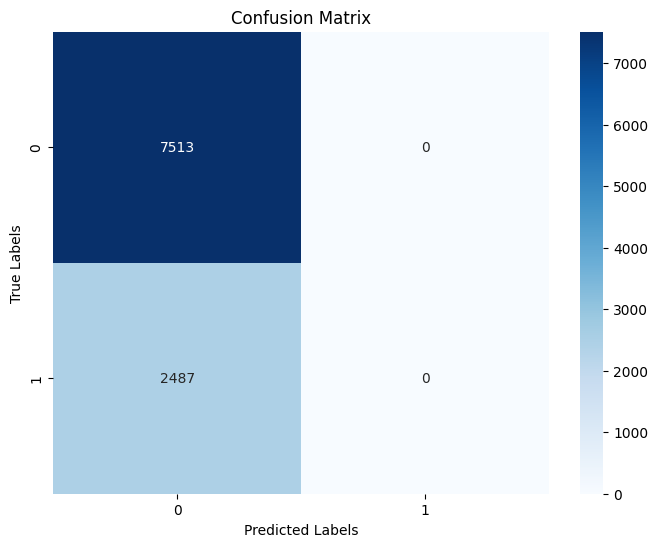

In [42]:
# Wyświetlenie macierzy konfuzji
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# 6. ROC Curve i współczynnik Giniego
y_val_probs_np = y_val_probs[:, 1].cpu().numpy()  # Prawdopodobieństwa dla klasy 1
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs_np)
roc_auc = auc(fpr, tpr)
gini = 2 * roc_auc - 1

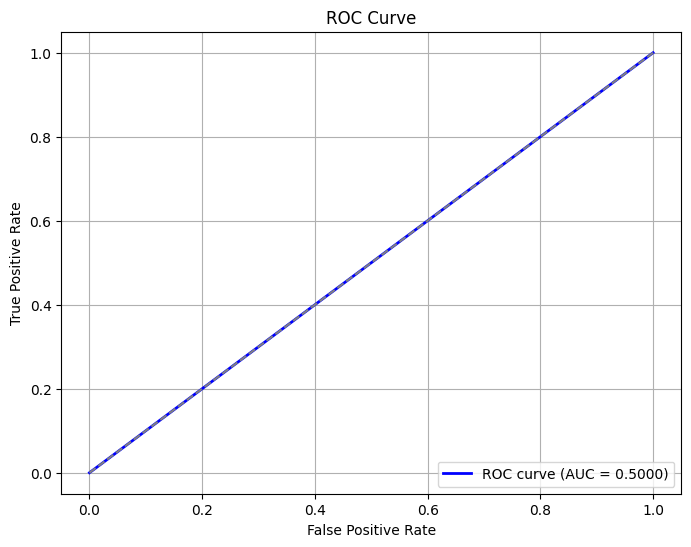

AUC: 0.5000
Gini Coefficient: 0.0000


In [44]:
# Rysowanie krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"AUC: {roc_auc:.4f}")
print(f"Gini Coefficient: {gini:.4f}")